# Produce synthetic HMM data

In [1]:
import sys
sys.path.append("../src/")

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

from mask import simulate_mask
from plotting import plot_profile, plot_hmap
from splitting import train_val_split

from hmm_data_generator.hmm_generator import simulate_profile

%matplotlib inline

In [2]:
SEED = 42

# Location where data matrix and masks will be stored.
PATH_TO_DATA = "/Users/sela/Desktop/recsys/data/hmm_data/100p_verify_gdl"

# To truncate profiles at empirical dropout times. The file contains a probbaility 
# vector where each entry of the vector holds a  probability that the female will never be 
# screened again.
PATH_TO_DROPOUT = '/Users/sela/phd/data/real/Pdropout_2Krandom.npy'

## Synthesize profiles

In [3]:
# NB: `n_timepoints` must be defined equally in utils.py (see src directory).
n_timepoints = 321
n_samples = 10

np.random.seed(SEED)

D = []
for num in tqdm(range(n_samples)):

    # Make synth screening profile.
    d = simulate_profile(n_timepoints, 0, 321)
    
    if sum(d) == 0:
        continue
    
    D.append(d)
    
D = np.array(D)

100%|██████████| 10/10 [00:00<00:00, 20.23it/s]


# Sparsening

In [4]:
# Probabilities for age at inital and final screening (16 to 96 yo divided into 321 time points) 
# derived from screening data.
#proba_init_age = np.load('/Users/sela/phd/data/real/Pinit_screen_2Krandom.npy')
#proba_dropout = np.load('/Users/sela/phd/data/real/Pdropout_2Krandom.npy')

# Sample screenings every `stepsize` entry.
#X = sample_screenings(X, stepsize=1, 
#                      proba_init_age=proba_init_age, 
#                      proba_dropout=proba_dropout)

In [5]:
parameters_simulate_mask = {
    'mask_screening_proba': np.array([0.05, 0.15, 0.40, 0.60, 0.20]),
    'memory_length': 10,
    'mask_level': 1000 #0.6
}

M = simulate_mask(
    D,
    mask_parameters=parameters_simulate_mask,
    path_dropout=PATH_TO_DROPOUT,
    seed=SEED
)

In [6]:
X = D * M

# Training and validation sets

In [7]:
prediction_window = 4

O_val, O_train = train_val_split(X, prediction_window, method='last_observed', seed=SEED)

X_val = X * O_val
X_train = X * O_train

# Inspect

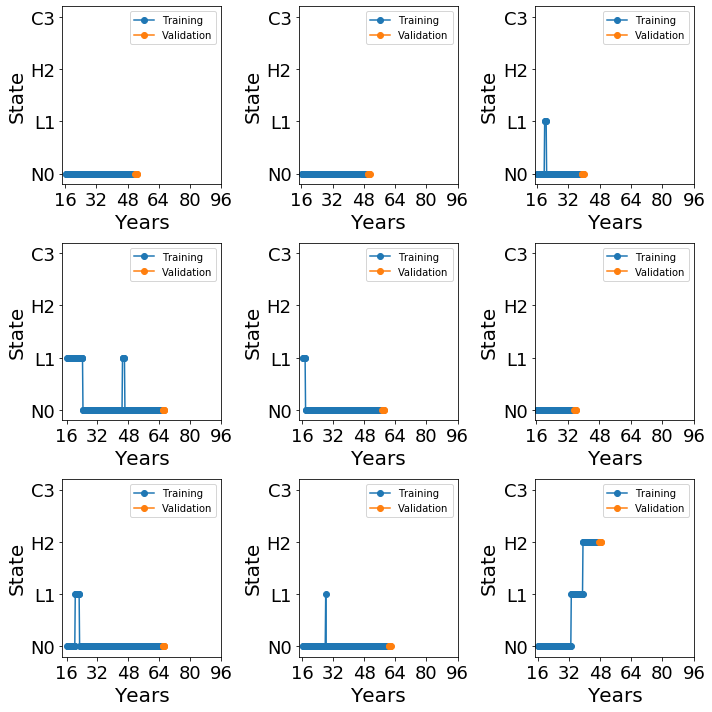

In [8]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for num, axis in enumerate(axes.ravel()):
    
    # Add plot to figure.
    plot_profile(X_train[num], axis, show=False, label='Training')
    plot_profile(X_val[num], axis, show=False, label='Validation')
    
    axis.legend()

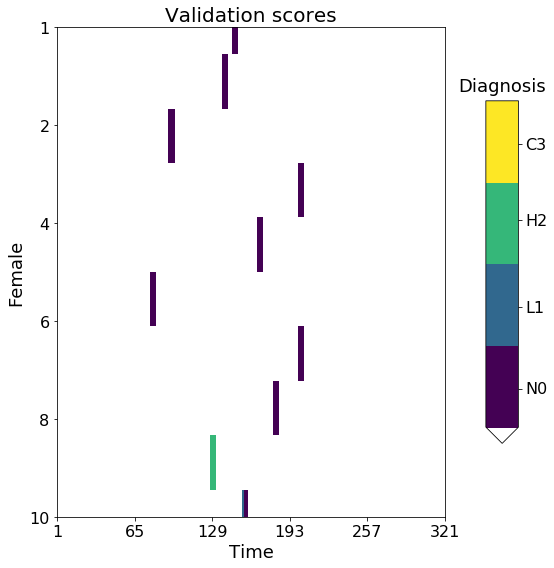

States: [1. 2. 3.]
Counts: [44  1  5]
Number of all-zero profiles: 0


In [9]:
fig = plt.figure(figsize=(8, 8))
plt.title("Validation scores", fontsize=20)
plot_hmap(fig, X_val)

vals, cnts = np.unique(X_val[X_val != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_val, axis=1) == 0))))

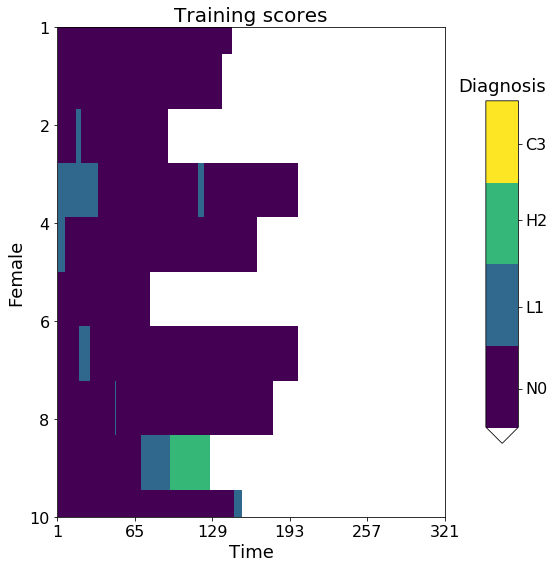

States: [1. 2. 3.]
Counts: [1337   89   33]
Number of all-zero profiles: 0


In [10]:
fig = plt.figure(figsize=(8, 8))
plt.title("Training scores", fontsize=20)
plot_hmap(fig, X_train)

vals, cnts = np.unique(X_train[X_train != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_train, axis=1) == 0))))

# Save data to disk

In [11]:
np.save(f'{PATH_TO_DATA}/X.npy', X)
np.save(f'{PATH_TO_DATA}/O_val.npy', O_val)
np.save(f'{PATH_TO_DATA}/O_train.npy', O_train)